In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass
set_seed(0)
plt.rcParams['figure.dpi'] = 150


In [3]:
# Figure size handling

dpi = 150
plt.style.use("../../../matplotlibrc")
plt.rcParams.update({"figure.dpi": dpi})



@dataclass
class FigureLayout:
    width_in_pt: float
    width_grid: int
    base_font_size: int = 8
    scale_factor: float = 1.0

    # matplotlib uses inch
    def _get_grid_in_inch(self, w_grid, h_grid):
        pt_to_inch = 1 / 72
        assert w_grid <= self.width_grid
        return (
            (w_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
            (h_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
        )

    def get_rc(self, w_grid, h_grid):
        return {
            "figure.figsize": self._get_grid_in_inch(w_grid, h_grid),
            "font.size": self.base_font_size * self.scale_factor,
        }
    
textwidth=469
fig_handler = FigureLayout(469,100)
params = fig_handler.get_rc(75,25)
plt.rcParams.update(params)

## Load data

We load in the toy mixture of Gaussians distribution in 2 dimensions as the base dataset.
We then define an augmented approximate distribution by changing the parameters of the mixture of gaussians.

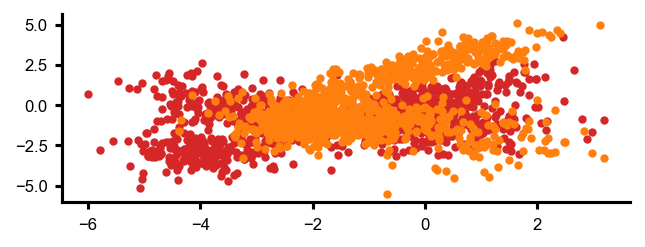

In [4]:
#Base distribution
toy_data = get_distribution("toy_2d")
datagen = toy_data()
data = datagen.sample(1000)

def update_toy_mog(datagen,means,covs,weights):
    datagen.means = means
    datagen.covs = covs
    datagen.weights = weights

    datagen.gaussians = [
        torch.distributions.MultivariateNormal(mean, covariance)
        for mean, covariance in zip(datagen.means, datagen.covariances)
    ]    
    return datagen

means2 = torch.Tensor([
            [0.0, 2.5],
            [-1.0, -0.5],
            [1.0, -2.0],
            [-2.0, -1.0],
        ])
            
covariances2 = torch.tensor(
                        [
                            [[1.0, 0.2], [0.2, 1.0]],
                            [[1.0, -0.7], [-0.7, 1.0]],
                            [[1.0, 0.0], [0.0, 1.0]],
                            [[0.5, 0.0], [0.0, 0.5]],
                        ]
                        )
weights2 = torch.tensor([0.3, 0.2, 0.1, 0.5])

#Augmented distribution
datagen2 = update_toy_mog(datagen,means2,covariances2,weights2)
data2 = datagen2.sample(1000)

#Plot the data
plt.scatter(data[:,0],data[:,1],color="C3")
plt.scatter(data2[:,0],data2[:,1],color="C1")

In [5]:
# subsample and compute optimal transport map

ndata = 10
plot_data = data[:ndata]
plot_data2 = data2[:ndata]
pairdist = torch.cdist(plot_data,plot_data2) #This is the cost matrix, with the norm being the euclidean distance between two points!
print(pairdist)

cost,transport = kuhn_transport(plot_data,plot_data2,norm=2)
indices = torch.arange(0,len(plot_data))
permutation = transport.argmax(dim=1)
plot_data2_copy = plot_data2[permutation]




tensor([[2.1614, 4.2141, 5.7055, 2.0034, 7.4913, 4.8794, 4.4335, 5.2918, 2.0234,
         2.3132],
        [1.0383, 1.8318, 3.3747, 1.1247, 5.0778, 2.6363, 1.6756, 3.0079, 0.8178,
         0.7740],
        [0.0609, 2.8801, 4.4264, 1.4048, 5.3957, 2.7919, 2.5926, 3.2028, 0.4049,
         0.2920],
        [1.7768, 3.5335, 5.0160, 1.3217, 7.0831, 4.4964, 3.8264, 4.9046, 1.5265,
         1.8634],
        [1.9722, 0.8979, 2.4432, 1.5200, 5.0491, 2.9121, 1.1665, 3.2116, 1.7089,
         1.7080],
        [1.9818, 0.8942, 2.4310, 1.5699, 4.9896, 2.8618, 1.1065, 3.1584, 1.7298,
         1.7165],
        [3.2032, 2.4213, 3.0358, 3.6411, 2.7947, 1.5464, 1.1749, 1.5427, 3.2601,
         2.9968],
        [3.1501, 1.7525, 2.6581, 1.8034, 6.8736, 4.7903, 2.9118, 5.0956, 2.7253,
         2.9576],
        [1.9892, 1.0879, 2.5046, 1.8880, 4.5493, 2.4478, 0.7246, 2.7305, 1.8273,
         1.7241],
        [2.2002, 5.0501, 6.6018, 3.1890, 6.6666, 4.1625, 4.7059, 4.5443, 2.4662,
         2.4672]])


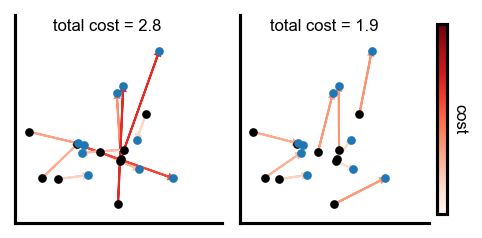

In [6]:
#Plot the optimal transport map
from mpl_toolkits.axes_grid1 import make_axes_locatable

params = fig_handler.get_rc(50,25)
plt.rcParams.update(params)

fig,axs = plt.subplots(1,2)

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.spines[['left', 'bottom']].set_visible(False)
    ax.tick_params(which = 'both', size = 0, labelsize = 0)

colors = plt.cm.Reds(pairdist/pairdist.max())
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
divider = make_axes_locatable(axs[1])
cbar = fig.colorbar(sm, ax=axs[1], fraction=0.046,pad=0.04,location='right')
# cbar.set_title("Cost")
cbar.ax.set_ylabel("cost",rotation=270,labelpad=10)
cbar.ax.set_yticks([])


axs[0].set_xlim(-5,4)
axs[0].set_ylim(-4,5)
for ind,p1,p2 in zip(indices,plot_data,plot_data2):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,ind].item()/pairdist.max().item()))
cost0 = pairdist[indices,indices].mean()
axs[0].annotate(f"total cost = {cost0.item():.1f}",(-1.0,4.5),xytext=(0,0),textcoords="offset points",ha="center",va="center",fontsize=8)
axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="black",s=10)
axs[0].scatter(plot_data2[:, 0], plot_data2[:, 1],color="C10",s=10)


axs[1].set_xlim(-5,4)
axs[1].set_ylim(-4,5)
for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
    axs[1].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))
cost1 = pairdist[indices,permutation].mean()
axs[1].annotate(f"total cost = {cost1.item():.1f}",(-1.0,4.5),xytext=(0,0),textcoords="offset points",ha="center",va="center",fontsize=8)
axs[1].scatter(plot_data[:, 0], plot_data[:, 1],color="black",s=10)
axs[1].scatter(plot_data2_copy[:, 0], plot_data2_copy[:, 1],color="C10",s=10)

fig.tight_layout()
fig.savefig("../../../plots/wasserstein_assignment.svg")

